In [127]:
import numpy as np
from scipy.interpolate import interp1d # For interpration
from scipy.optimize import minimize_scalar # For optimization

import quantecon as qe
import matplotlib.pyplot as plt

import requests # For download data from github
from io import StringIO # For change txt file into array

# **Introduction**

In the previous lecture, we solved a Robinson Crusoe model using the Backward Induction method. In the model, Robinson faced a decision in each period regarding how to allocate resources between consumption and investment. The key to solving the model was recognizing that in period $T$, Robinson would use all his resources for production and then consume the entire output.

In this lecture, we apply the Backward Induction algorithm to analyze a **life cycle model**.  
In this model, a consumer’s labor income follows a Markov process during their working years, with the mean income increasing as they age. Upon reaching retirement, the consumer no longer receives random income but instead receives a fixed pension. Clearly, the decision-making behavior of the consumer differs significantly between their working years and retirement, presenting unique challenges for applying the Backward Induction algorithm.

This model is adapted from Chapter 3, Section 9 of Yamada et al. (2024) and is a simplified version of the model developed by Gourinchas and Parker (2002).

# **Overview of the Model**

We assume there is a consumer with a maximum lifespan of $T$ periods. In each period, the consumer faces a risk of death. Let $s_{t+1} \in (0,1)$ denote the survival probability from period $t$ to period $t+1$. Since the maximum lifespan is $T$, we set $s_{T+1} = 0$.  
Assuming no early death risk, the survival probability at age 0 is $s_0 = 1$. Therefore, the cumulative survival probability from age 0 to age $t$ is given by:
$$
S_t \equiv \prod_{j=0}^t s_j.
$$

The consumer’s objective function can be expressed in sequential form as:
$$
\max_{\{c_t\}_{t=0}^T} \sum_{t=0}^T \beta^t S_t \mathbb{E} u(c_t).
$$

The consumer's budget constraints before and after retirement are as follows:
$$
c_t + a_{t+1} \leq \eta_t z + (1+r)a_t, \quad \text{for} \quad 0 \leq t < tr,
$$
$$
c_t + a_{t+1} \leq ss + (1+r)a_t, \quad \text{for} \quad tr \leq t < T,
$$
where $a_0$ is given.

Here, we assume the consumer retires at period $tr$. Before retirement, they receive exogenous labor income $\eta_t z$, where $\eta_t$ represents deterministic labor productivity that increases with age, and $z$ is a stochastic variable following a Markov process with transition probabilities $p(z, z')$. Additionally, $ss$ represents fixed pension income after retirement.

**Note**: The key difference between this model and the one proposed by Miyamoto and Yoshino (2017) lies in the behavior of the consumer after retirement. The consumer can still make saving and investment decisions, but they must consume all their wealth in the final period $T$.

The optimal decisions of the young consumer can be represented by the following Bellman equation:
$$
V_t(a, z) = \max_{c, a'} \left\{ u(c) + \beta s_{t+1} \sum_{z'} p(z, z') V_{t+1}(a', z') \right\}
$$
subject to:
$$
c + a' \leq \eta_t z + (1+r)a,
$$
for $0 \leq t < tr$.

After retirement, the Bellman equation becomes:
$$
V_t(a) = \max_{c, a'} \left\{ u(c) + \beta s_{t+1} V_{t+1}(a') \right\}
$$
subject to:
$$
c + a' \leq ss + (1+r)a,
$$
for $tr \leq t \leq T$.

In period $T$, the consumer consumes all their wealth, so $a_{T+1} = 0$ and $V_{t+1}(a_{T+1}) = 0$.

# **Algorithm**

**1. Discretize the State Space**  
Transform the state variables $a,z$ into discretized grids:  
$$
\{a_i\}_{i=0}^{N_a} \equiv \text{Grid}(a) \\
\{z_j\}_{j=0}^{N_z} \equiv \text{Grid}(z)
$$

**2. Initialize the Value Function for Period $T+1$**  
Set the value function for period $T+1$ as $V_{T+1}(a_{T+1}) = 0$.

**3. Backward Recursion**  

**Step A:**  
For each period after retired $t = T, T-1, \dots, tr$:  
Given $\forall a \in \text{Grid}(a)$, compute the value function $V_t(a)$ as follows:
$$
V_t(a) = \max_{a'} u(c) + \beta s_{t+1} V_{t+1}(a') \\
\text{s.t.} \quad
c = ss + (1+r)a - a'
$$

**Step B:**  
Set the value function for period $tr$ according to the result of Step A.
$$V_{tr}(a,z) = V_{tr}(a)$$
For each period before retired $t = tr-1, tr-2, \dots, 0$:  
Given $\forall a,z \in \text{Grid}(a) \times \text{Grid}(z)$, compute the value function $V_t(a,z)$ as follows:
$$
V_t(a,z) = \max_{c,a'} \{ u(c) + \beta s_{t+1} \sum_{z'} p(z,z')V_{t+1}(a',z')  \} \\
\text{s.t.} \quad c + a' \leq \eta_t z + (1+r)a \\
$$

## **Inputs**

For computation, we need the survival probabilities for each age, $\{s_t\}_{t=0}^{T}$, as well as the labor productivity values, $\{\eta_t\}_{t=0}^{tr}$. These data are provided on the GitHub page of Yamada et al. (2024).

In [128]:
# Request data in github
url1 = 'https://raw.githubusercontent.com/quant-macro-book/chapter3/master/Python/surv.csv'
response1 = requests.get(url1)
url2 = 'https://raw.githubusercontent.com/quant-macro-book/chapter3/master/Python/earnings_profiles.csv'
response2 = requests.get(url2)

# Read the downloaded data
s_csv = response1.text
η_csv = response2.text
# Change txt file into arrays
s_array = np.genfromtxt(StringIO(s_csv), delimiter=',', skip_header=1, usecols=1)
η_array = np.genfromtxt(StringIO(η_csv), delimiter=',', skip_header=1, usecols=1)

86


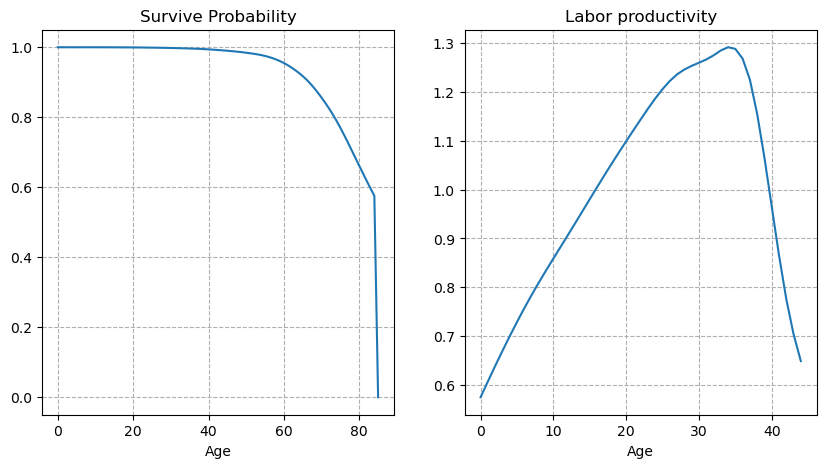

In [129]:
print(len(s_array))

# Draw the graph
plt.figure(figsize=(10, 5))
age1 = np.arange(len(s_array))
age2 = np.arange(len(η_array))

plt.subplot(1, 2, 1)
plt.plot(age1,s_array)
plt.xlabel('Age')
plt.title('Survive Probability')
plt.grid(ls="--")

plt.subplot(1, 2, 2)
plt.plot(age2,η_array)
plt.xlabel('Age')
plt.title('Labor productivity')
plt.grid(ls="--")
plt.show()

The following class is used to store the necessary parameters, arrays, and functions.

In [130]:
class life_cycle_model:
    def __init__(self,β,γ,r,ss,ρz,σz,grid_size_z,grid_size_a,amax,amin,η_array,s_array):
        #parameters
        self.β = β      # discount rate
        self.γ = γ      # risk aversion
        self.r = r      # Interest rate
        self.ss = ss    # Social security
        
        # Discrete the stochastic process of income 
        mc = qe.markov.tauchen(grid_size_z, ρz, σz)
        self.grid_size_z = grid_size_z              # grid size of income
        self.grid_z = np.exp(mc.state_values)       # grid of income
        self.P = mc.P                               # transition probability matrix
        
        # Discrete the wealth
        self.grid_size_a = grid_size_a                      # grid size of wealth
        self.grid_a = np.linspace(amin,amax,grid_size_a)    # grid of wealth

        # exogenous series 
        self.η_array = η_array      # labor productivity growth
        self.s_array = s_array      # survive probability
        self.ret_age = len(η_array) # retire age
        self.max_age = len(s_array) # maiximal age
        

    def u(self,c):
        γ = self.γ
        
        if γ == 1:
            return np.log(c)
        else:
            return c**(1-γ)/(1-γ)

The following function assigns values to the model's parameters.

In [131]:
def calibration(η_array,s_array):
    β = 0.98
    γ = 1.0
    r = 0.04
    ss = 0.5

    ρz = 0.94
    σz = 0.5
    grid_size_z = 3
    
    grid_size_a = 100
    amax = 40
    amin = 1e-5

    return life_cycle_model(β,γ,r,ss,ρz,σz,grid_size_z,grid_size_a,amax,amin,η_array,s_array)

## **Backward Induction After Retirement**

Given the value function for period $t+1$, $V_{t+1}(a')$, the current period's value function $V_t(a)$ can be solved as follows:
$$
V_t(a) = \max_{a'} \left\{ u(c) + \beta s_{t+1} V_{t+1}(a') \right\}
$$
subject to:
$$
c = ss + (1+r)a - a'.
$$

We break this process down into two steps:

### **Step 1: Compute the Function Inside the Maximization**

Given the value function $V_{t+1}(a')$ from period $t+1$ and the capital values $a$ and $a'$ for both periods, we calculate the value inside the maximization using the function `Bellman(model, a, a_prime, v_prime, age)`:

This function works as follows:
$$
c = ss + (1+r)a - a'
$$
$$
\begin{cases}
\text{If} \quad c > 0, & \text{Bellman}(a, a', \text{age}; V_{t+1}) = u(c) + \beta s_{t+1}(\text{age}) V_{t+1}(a'), \\
\text{If} \quad c \leq 0, & \text{Bellman}(a, a', \text{age}; V_{t+1}) = -\infty.
\end{cases}
$$

Note that we include the consumer's age as a state variable since the survival probability $s_{t+1}$ changes with age.


In [132]:
def Bellman(model,a,a_prime,v_prime_cons,age):
    
    # unpack the model
    r = model.r
    β = model.β
    ss = model.ss
    s_array = model.s_array
    u = model.u

    if a_prime < 0:
        val = -10000000

    # calculate the consumption
    c = ss + (1+r)*a - a_prime
    
    if c <= 0 :
        val = -10000000
    else:
        val = u(c) + β * s_array[age] * v_prime_cons(a_prime)
    
    return - val

### **Step 2: Compute the Value Function and Policy Function**  
Next, we use the function `Induction_onestep(model, v_prime,age)` to solve the following optimization problem, which yields both the value function and the policy function:
$$
V_t(a,age) = \max_{a_{t+1}} \text{Bellman}(a, a',age'; V_{t+1}),
$$
$$
a_{t+1}^*(a,age) = \arg\max_{a_{t+1}} \text{Bellman}(a, a',age'; V_{t+1}).
$$

In [133]:
def Induction_onestep(model,v_prime,age):
    # Unpack
    grid_a = model.grid_a
    r = model.r
    ss = model.ss

    # interplate the value function v_{t+1}(a_{t+1})
    v_prime_con = interp1d(grid_a,v_prime, kind="cubic",fill_value='extrapolate')
    
    # 1. Define v(a) and a'(a)
    v = np.zeros_like(grid_a)
    policy = np.zeros_like(grid_a)

    for i,a in enumerate(grid_a):        
        objective = lambda a_prime: Bellman(model,a,a_prime,v_prime_con,age)
        wealth = (1+r)*a + ss
        
        # use minimizer to find the value function and policy function
        sol = minimize_scalar(objective,bounds=(0.0,wealth-1e-10), method="bounded")
        policy[i] = sol.x
        v[i] = - sol.fun

    return v, policy

### **Multi-period Backward Induction after retired**

Using the tools developed in Step 1 and 2, we solve for the value functions and policy functions after retired.

In [134]:
def Backward_indction(model):
    # Unpack the model
    max_age = model.max_age
    ret_age = model.ret_age
    grid_size_a = model.grid_size_a

    vfunc = np.zeros((max_age+1,grid_size_a))
    poli_func = np.zeros((max_age+1,grid_size_a))

    for age in range(max_age,ret_age,-1): # (start,end-1,-1)
        # given v_{t+1}(a_{t+1}), in the first induction, v_T(a_T)=0
        v_prime = vfunc[age,:]
    
        # apply the method
        v,policy = Induction_onestep(model,v_prime,age-1)
        vfunc[age-1,:] = v
        poli_func[age-1,:]= policy
    
    return vfunc,poli_func

In [135]:
# Apply the method
model = calibration(η_array,s_array)
vfunc_old,poli_func_old = Backward_indction(model)

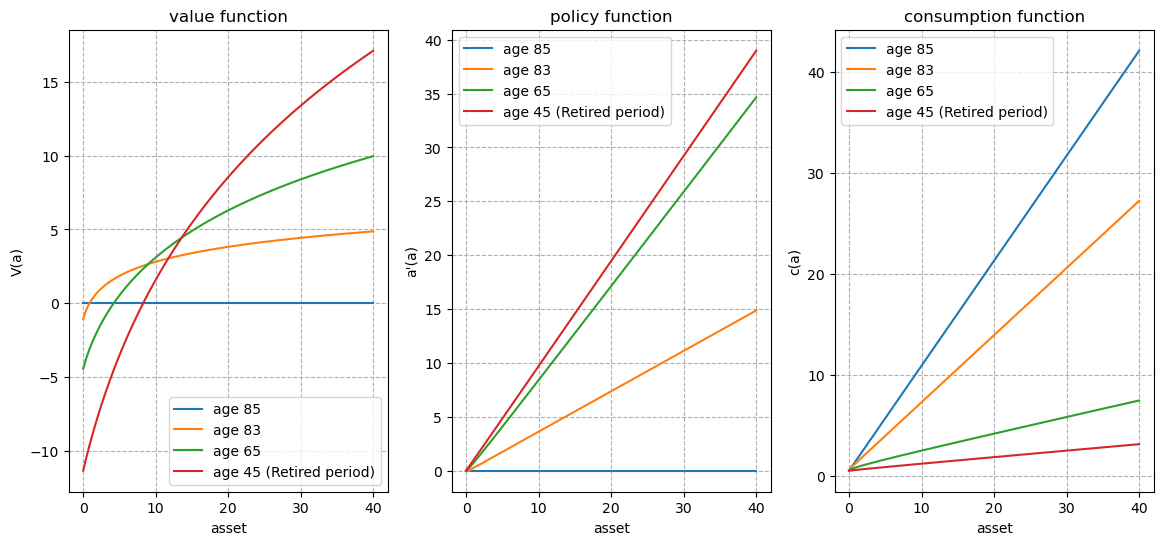

In [136]:
# Draw the graph
grid_a = model.grid_a
ret_age = model.ret_age
max_age = model.max_age
ss = model.ss
r = model.r

c_func = grid_a * (1+r) + ss - poli_func_old

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,6))
ax1.plot(grid_a,vfunc_old[max_age,:],label='age 85')
ax1.plot(grid_a,vfunc_old[max_age-2,:],label='age 83')
ax1.plot(grid_a,vfunc_old[max_age-21,:],label='age 65')
ax1.plot(grid_a,vfunc_old[ret_age,:],label='age 45 (Retired period)')
ax1.set(xlabel="asset",ylabel="V(a)",title="value function")
ax1.grid(ls="--")
ax1.legend()

ax2.plot(grid_a,poli_func_old[max_age,:],label='age 85')
ax2.plot(grid_a,poli_func_old[max_age-2,:],label='age 83')
ax2.plot(grid_a,poli_func_old[max_age-21,:],label='age 65')
ax2.plot(grid_a,poli_func_old[ret_age,:],label='age 45 (Retired period)')
ax2.set(xlabel="asset",ylabel="a'(a)",title="policy function")
ax2.grid(ls="--")
ax2.legend()

ax3.plot(grid_a,c_func[max_age,:],label='age 85')
ax3.plot(grid_a,c_func[max_age-2,:],label='age 83')
ax3.plot(grid_a,c_func[max_age-21,:],label='age 65')
ax3.plot(grid_a,c_func[ret_age,:],label='age 45 (Retired period)')
ax3.set(xlabel="asset",ylabel="c(a)",title="consumption function")
ax3.grid(ls="--")
ax3.legend()

plt.show()

It is particularly worth noting how the consumption function changes across different age groups. **As age increases, consumption for the same level of assets also rises. This implies that older individuals have a higher propensity to consume.**

This suggests that the model by Miyamoto and Yoshino (2017) can be viewed as an extreme simplification of this model.

## **Backward Induction Before Retired**

### **Step 1: Compute the Function Inside the Maximization**

Given the value function $V_{t+1}(a', z')$ from period $t+1$, the current income process $z$, and the capital values $a$ and $a'$, we calculate the value inside the maximization using the function `Bellman_work(model, a, a_prime, z, z_idx, v_prime_con, age)`:

This function works as follows:
$$
c = \eta(\text{age}) \cdot z + (1+r)a - a'
$$
$$
\begin{cases}
\text{If} \quad c > 0, & \text{Bellman\_work}(a, a', z, \text{age}; V_{t+1}) = u(c_t) + \beta s_{t+1}(\text{age}) \sum_{z'} p(z, z') V_{t+1}(a', z'), \\
\text{If} \quad c \leq 0, & \text{Bellman\_work}(a, a', z, \text{age}; V_{t+1}) = -\infty.
\end{cases}
$$

Although the inputs to the Bellman equation become more complex as the state variables increase, the basic algorithm remains unchanged.

**Note:**  
Given that the value function is continuous in assets but discrete in the income process, we employ a special technique to compute the expectation of the future value function, $V_{t+1}(a', z')$:
- For each possible $z'$, we calculate the value of $V_{t+1}(a', z')$ for the given $a'$ using interpolation (this will be explained in the next step).
- After obtaining the possible values of $V_{t+1}(a', z')$, we multiply them by the transition probabilities $p(z, z')$ and sum them to calculate the expected future value function.

In [137]:
def Bellman_work(model,a,a_prime,z,z_idx,v_prime_con,age): 
    """
    Bellman equation for workers

    model: name tuples of parameters and arrays
    a,a_prime: asset in period t and t+1
    z,z_idx:   value and index of income markov process
    v_prime_con: Interporized value function for v' for workers
    age: age of the agent
    """
    # unpack the model
    r = model.r
    β = model.β
    s_array = model.s_array
    u = model.u
    η_array = model.η_array
    P = model.P
    grid_size_z = model.grid_size_z

    # utility in period t
    wealth = (1+r)*a + η_array[age]*z
    c = wealth - a_prime

    # possible value of next period value function
    vnext_z = np.zeros(grid_size_z)
    for z in range(grid_size_z):
        vnext_z[z] = v_prime_con[z](a_prime)

    # value function
    val = u(c) + s_array[age] * β * np.sum(P[z_idx,:] * vnext_z)

    if c <= 0:
        val = - 1000000

    if wealth <0:
        val = - 1000000

    return - val

### **Step 2: Compute the Value Function and Policy Function**

Next, we use the function `Induction_onestep_work(model, v_prime)` to solve the following optimization problem, yielding both the value function and the policy function:
$$
V_t(a) = \max_{a'} \text{Bellman\_work}(a, a', z, \text{age}; V_{t+1}),
$$
$$
a'^*(a) = \arg\max_{a'} \text{Bellman\_work}(a, a', z, \text{age}; V_{t+1}).
$$

**Note:**  
Considering that the value function is continuous in assets and discrete in the income process, we apply special techniques to ensure the precision of the optimization.

Specifically, when using the discretized future value function $V_{t+1}(a', z')$, we interpolate $V_{t+1}$ in the $a'$ direction for each possible $z'$ value.  
As a result, for each possible value of $z'$, we obtain a continuous value function in the $a'$ direction.  
(This continuous value function in the asset direction is also used in the previous step for calculating the expectation of the value function.)

In [138]:
def Induction_onestep_work(model,v_prime,age):
    # Unpack
    grid_a = model.grid_a
    grid_z = model.grid_z
    size = model.grid_size_a, model.grid_size_z
    r = model.r

    # Define v(k) and kp(k)
    v = np.zeros(size)
    policy = np.zeros(size)

    v_prime_con = []
    for z_idx,z in enumerate(grid_z):
        v_prime_con.append( interp1d(grid_a,v_prime[:,z_idx], kind="cubic",fill_value='extrapolate') )

    for i,a in enumerate(grid_a):        
        for z_idx,z in enumerate(grid_z):
           
            objective = lambda a_prime: Bellman_work(model,a,a_prime,z,z_idx,v_prime_con,age)
            
            wealth = (1+r)*a + η_array[age]*z
            # use minimizer to find the value function and policy function
            sol = minimize_scalar(objective,bounds=(0.0,wealth-1e-10), method="bounded")
            policy[i,z_idx] = sol.x
            v[i,z_idx] = - sol.fun

    return v, policy

### **Multi-Period Backward Induction Before Retirement**

The algorithm for this part has already been detailed in the previous sections and will not be repeated here.


In [139]:
def Backward_indction_work(model,v_prime_old,poli_old):
    # Unpack the model
    max_age = model.max_age
    ret_age = model.ret_age
    grid_size_a = model.grid_size_a
    grid_size_z = model.grid_size_z

    vfunc = np.zeros((ret_age+1,grid_size_a,grid_size_z))
    poli_func = np.zeros((ret_age+1,grid_size_a,grid_size_z))
    
    # In the first induction, value funciton and policy function are the result of old
    temp = np.reshape(v_prime_old,(grid_size_a,1))
    vfunc[ret_age,:,:] = temp
    temp2 = np.reshape(poli_old,(grid_size_a,1))
    poli_func[ret_age,:,:] = temp2

    for age in range(ret_age,0,-1): # (start,end-1,-1)
        # given v_{t+1}(a_{t+1})
        v_prime = vfunc[age,:,:]
    
        # apply the method
        v,policy = Induction_onestep_work(model,v_prime,age-1)
        vfunc[age-1,:,:] = v
        poli_func[age-1,:,:]= policy
    
    return vfunc,poli_func

In [140]:
model = calibration(η_array,s_array)
# Backward induction after retired
vfunc_old,poli_func_old = Backward_indction(model)

# set the first induction for period before retired
v_prime_old = vfunc_old[ret_age,:]
poli_old = poli_func_old[ret_age,:]
# Backward induction before retired
vfunc_yng,poli_func_yng = Backward_indction_work(model,v_prime_old,poli_old)

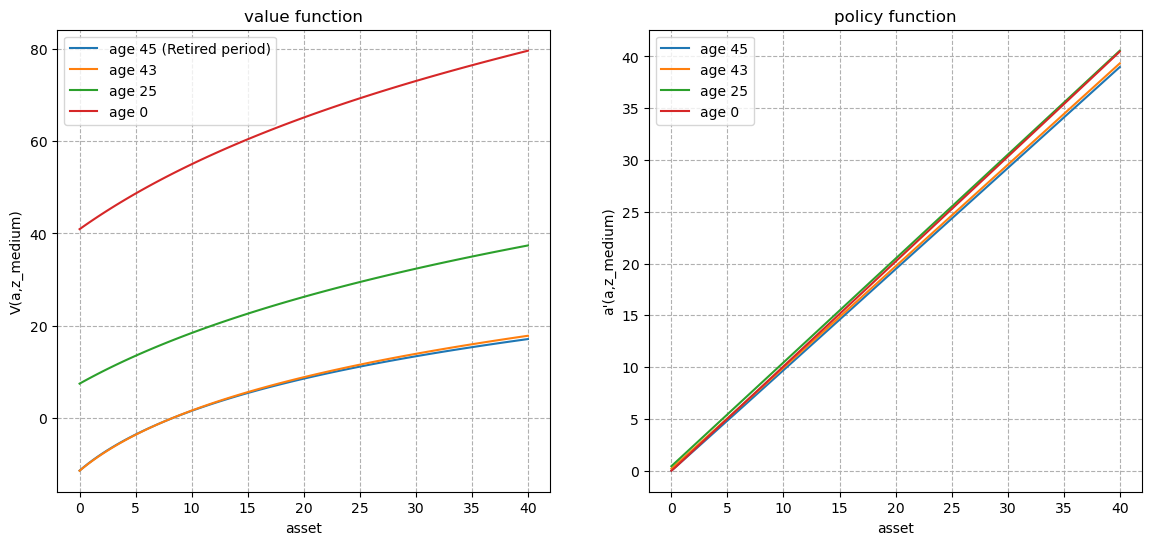

In [141]:
# Draw the graph
grid_a = model.grid_a
ret_age = model.ret_age
max_age = model.max_age
z_idx = 1

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
ax1.plot(grid_a,vfunc_yng[ret_age,:,1],label='age 45 (Retired period)')
ax1.plot(grid_a,vfunc_yng[ret_age-2,:,1],label='age 43')
ax1.plot(grid_a,vfunc_yng[ret_age-20,:,1],label='age 25')
ax1.plot(grid_a,vfunc_yng[0,:,1],label='age 0 ')
ax1.set(xlabel="asset",ylabel="V(a,z_medium)",title="value function")
ax1.grid(ls="--")
ax1.legend()

ax2.plot(grid_a,poli_func_yng[ret_age,:,1],label='age 45')
ax2.plot(grid_a,poli_func_yng[ret_age-2,:,1],label='age 43')
ax2.plot(grid_a,poli_func_yng[ret_age-20,:,1],label='age 25')
ax2.plot(grid_a,poli_func_yng[0,:,1],label='age 0')
ax2.set(xlabel="asset",ylabel="a'(a,z_medium)",title="policy function")
ax2.grid(ls="--")
ax2.legend()

plt.show()

Thus, it is evident that **the policy function for the consumer remains relatively unchanged during their younger years**, in stark contrast to the significant differences observed after retirement.